In [1]:
import sys
import os

def get_dir_n_levels_up(path, n):
    # Go up n levels from the given path
    for _ in range(n):
        path = os.path.dirname(path)
    return path

proj_root = get_dir_n_levels_up(os.path.abspath("__file__"), 4)
sys.path.append(proj_root)

import yaml
import torch
import glob
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from dqn.opinion_dynamics.opinion_dqn import AgentDQN
from dqn.opinion_dynamics.utils.my_logging import setup_logger
from dqn.opinion_dynamics.utils.experiment import build_environment, process_experiment

from dynamic_programming.opinion_dynamics.common.viz import plot_opinions_over_time, visualize_policy_from_env


def instantiate_agent(exp_subdir_path: str) -> AgentDQN:
    """
    Instantiate an AgentDQN using the configuration stored in a YAML file 
    in the provided experiment subdirectory. The agent is created with the 
    given training and validation environments and loads its previous state.
    
    Args:
        exp_subdir_path (str): Path to the experiment subdirectory containing the config YAML and checkpoint files.
     
    Returns:
        AgentDQN: An instance of AgentDQN initialized using the experiment configuration and saved state.
    """
    # Assume the YAML configuration is stored as 'config.yaml' in the experiment folder.
    config_path = os.path.join(exp_subdir_path, "cfg.yaml")
    if not os.path.exists(config_path):
        raise FileNotFoundError(f"Config file not found at {config_path}")
    
    with open(config_path, "r") as f:
        config = yaml.safe_load(f)
    
    # Instantiate the agent.
    # The resume_training_path is set to the experiment folder so that the agent loads saved weights/stats.
    agent = AgentDQN(
        resume_training_path=exp_subdir_path,
        experiment_name=config["experiment"],
        config=config,
        save_checkpoints=False,  # you can set this as needed
        logger=setup_logger("dqn", level=logging.ERROR)
    )
    
    return agent

def run_policy_agent(env, agent, max_steps=10):
    """
    Run the simulation using the agent’s policy (exploitation only).
    
    Args:
        env: The environment (which must have a reset and step method).
        agent: An already-trained AgentDQN instance.
        max_steps: Maximum number of steps to run.
        
    Returns:
        opinions_over_time: Array of opinions (states) over time.
        time_points: Array of time stamps.
        rewards_over_time: Array of rewards collected at each step.
        actions_over_time: Array of actions taken at each step.
    """
    time_points = []
    rewards_over_time = []
    actions_over_time = []  # New: record the actions used.
    opinions_over_time = []
    
    current_time = 0.0
    # Reset environment
    state, _ = env.reset()
    opinions_over_time.append(state.copy())
    
    for step in range(max_steps):
        # Convert state to a batched tensor (batch size = 1)
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        # Use the agent in exploitation mode (epsilon=0, random_action=False)
        # The agent.select_action returns (action, beta_idx, q_value)
        action, _, _, _ = agent.select_action(state_tensor, epsilon=0.0, random_action=False)
        # action is returned as a NumPy array with shape (1, n_agents)
        action = np.squeeze(action)  # Now action has shape (n_agents,)
        actions_over_time.append(action.copy())
        
        # Apply the action in the environment.
        next_state, reward, done, truncated, _ = env.step(action, env.tau)
        opinions_over_time.append(next_state.copy())
        rewards_over_time.append(reward)
        time_points.append(current_time)
        
        current_time += env.tau
        state = next_state
        
        if done or truncated:
            print(f"Simulation ended at step {step}: done={done}, truncated={truncated}")
            break

    return (np.array(opinions_over_time),
            np.array(time_points),
            np.array(rewards_over_time),
            np.array(actions_over_time))

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29484\1225861293.py:18: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\utils\experiment.py:145: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(train_stats_file)
C:\Users\

Running experiment number 1 out of 24: D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025Apr29-212301_configs\0000_optim.args_.eps_1e-06__optim.args_.lr_1e-05__agent_params.args_.action_w_noise_amplitude_0\0


d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\opinion_dqn.py:305: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(training_stats_file)
d:\Work\rep

Simulation ended at step 19: done=True, truncated=False
Running experiment number 2 out of 24: D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025Apr29-212301_configs\0000_optim.args_.eps_1e-06__optim.args_.lr_1e-05__agent_params.args_.action_w_noise_amplitude_0\1
Simulation ended at step 21: done=True, truncated=False
Running experiment number 3 out of 24: D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025Apr29-212301_configs\0001_optim.args_.eps_1e-06__optim.args_.lr_1e-05__agent_params.args_.action_w_noise_amplitude_0.1\0
Simulation ended at step 17: done=True, truncated=False
Running experiment number 4 out of 24: D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025Apr29-212301_configs\0001_optim.args_.eps_1e-06__optim.args_.lr_1e-05__agent_params.args_.action_w_noise_amplitude_0.1\1
Running experiment number 5 out of 24: D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025Apr29-212301_co

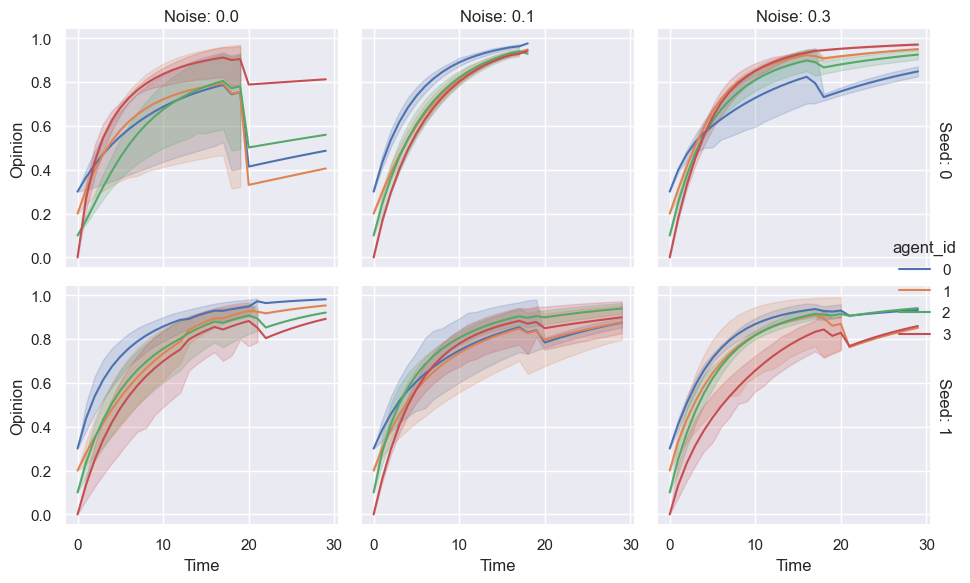

In [2]:
EXP_DIR = r"2025Apr29-212301_configs"
EXPERIMENTS_ROOT_DIR = r"D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results"
EXPERIMENTS_ROOT = os.path.join(EXPERIMENTS_ROOT_DIR, EXP_DIR)
GAMMA = 0.9

# Step 1: Get metadata (seed, noise, etc.) from your existing util
metadata_df = process_experiment(EXPERIMENTS_ROOT)
# For each sub_experiment_path, select only the ones where the epoch_type is "training", and select only the row with the maximum frame_stamp
metadata_df = metadata_df[
    (metadata_df["epoch_type"] == "training")
    & (
        metadata_df["frame_stamp"]
        == metadata_df.groupby("sub_experiment_path")["frame_stamp"].transform(max)
    )
].reset_index(drop=True)

# Step 2: Run agents and gather reward trajectories
all_runs = []

for i, row in metadata_df.iterrows():
    print(
        f"Running experiment number {i+1} out of {len(metadata_df)}: {row['sub_experiment_path']}"
    )
    subdir = row["sub_experiment_path"]
    noise = float(row.get("sub_exp_cfg_agent_params.args_.action_w_noise_amplitude", 0))
    seed = row.get("seed", "unknown")

    try:
        env = build_environment()
        agent = instantiate_agent(subdir)
        opinions, times, rewards, actions = run_policy_agent(env, agent, max_steps=30)

        discounted_return = sum((GAMMA**t) * r for t, r in enumerate(rewards))

        for step, (t, opinion_vec) in enumerate(zip(times, opinions)):
            for agent_id, opinion_val in enumerate(opinion_vec):
                all_runs.append(
                    {
                        "noise_amplitude": noise,
                        "seed": seed,
                        "time": t,
                        "step": step,
                        "agent_id": agent_id,
                        "opinion": opinion_val,
                        "experiment": os.path.basename(subdir),
                    }
                )

    except Exception as e:
        print(f"❌ Failed to run experiment at {subdir}: {e}")
        continue

# Step 3: Plot
df = pd.DataFrame(all_runs)
df["seed"] = df["seed"].astype(str)
df["noise_amplitude"] = df["noise_amplitude"].astype(str)

g = sns.FacetGrid(
    df,
    row="seed",
    col="noise_amplitude",
    hue="agent_id",
    margin_titles=True,
    sharey=True,
)
g.map_dataframe(sns.lineplot, x="step", y="opinion")
g.set_axis_labels("Time", "Opinion")
g.set_titles(row_template="Seed: {row_name}", col_template="Noise: {col_name}")
g.add_legend()
plt.tight_layout()
plt.show()

In [3]:
df

,noise_amplitude,seed,time,step,agent_id,opinion,experiment
0,0.0,0,0.0,0,0,0.300000,0
1,0.0,0,0.0,0,1,0.200000,0
2,0.0,0,0.0,0,2,0.100000,0
3,0.0,0,0.0,0,3,0.000000,0
4,0.0,0,0.1,1,0,0.385480,0
...,...,...,...,...,...,...,...
2119,0.3,1,1.6,16,3,0.872200,1
2120,0.3,1,1.7,17,0,0.974237,1
2121,0.3,1,1.7,17,1,0.967567,1
2122,0.3,1,1.7,17,2,0.950695,1
